### Libraries

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load data

In [34]:
path = '/content/gdrive/MyDrive/Tesi/data/Dati/'
plot_path = path + 'plot/production_weather_OHE/'
results_path = path + 'results/'
data_path = path + 'data/production/data_prod_weather_encoded.xlsx'
data = pd.read_excel(data_path)

### Pre-processing

In [11]:
data = data.set_index("datetime")
data_initial = data.copy()

In [12]:
scaler = MinMaxScaler()
data['produzionePV'] = scaler.fit_transform(data[['produzionePV']])
data['solarradiation'] = scaler.fit_transform(data[['solarradiation']])
data['solarenergy'] = scaler.fit_transform(data[['solarenergy']])

# Models

### SARIMA

In [13]:
# Split the data into training and testing sets
train_data = data.loc['2013-01-01':'2013-10-31']
test_data = data.loc['2013-11-01':'2013-11-01']
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
# Define the SARIMA model
model_SARIMA = SARIMAX(train_data.produzionePV, order=(1, 1, 1), seasonal_order=(1, 0, 0, 24),
                enforce_stationarity=False, enforce_invertibility=False)

# Fit the model to the training data
model_fit = model_SARIMA.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [18]:
# Make predictions on one day
date = '2013-07-01'
end = date + ' 23:00:00'
predictions_S = model_fit.predict(start=date , end=end, dynamic=True)
actual_S = data.produzionePV.loc[date]
test_results_S = pd.concat([actual_S, predictions_S], axis=1)
#test_results_S.to_csv('test_results_SARIMA_010713.csv')

In [ ]:
# Make predictions
date = '2013-01-02'
end = '2013-12-31' + ' 23:00:00'
predictions_S = model_fit.predict(start=date , end=end, dynamic=True)
test_results_S = pd.concat([data, predictions_S], axis=1)
test_results_S.to_csv('test_results_SARIMA.csv')

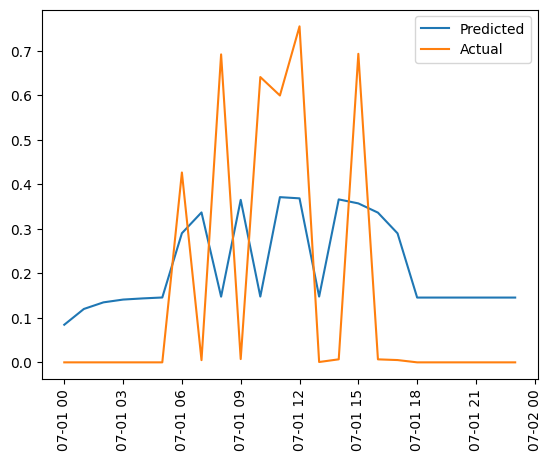

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot the predicted values and the actual values for the selected day
plt.plot(predictions_S, label='Predicted')
plt.plot(actual_S, label='Actual')
plt.xticks(rotation='vertical')
plt.legend()
plt.show()
plt.savefig('test_results_predictions_SARIMA_010713.png')

In [20]:
mse_S = mean_squared_error(actual_S, predictions_S)
mae_S = mean_absolute_error(actual_S, predictions_S)
rmse_S = math.sqrt(mse_S)
print('mse SARIMA: ' + str(mse_S))
print('mae SARIMA: ' + str(mae_S))
print('rmse SARIMA: ' + str(rmse_S))

mse SARIMA: 0.07008148302284102
mae SARIMA: 0.23257781563549937
rmse SARIMA: 0.2647290747591602


## LSTM & GRU

In [21]:
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = [a for a in df_as_np[i : i + window_size]]
    X.append(row)
    label = df_as_np[i + window_size, 0]
    y.append(label)
  return np.array(X), np.array(y)

In [22]:
# Defining the window size
win_size = 3
X1, y1 = df_to_X_y(data, win_size)
y1 = y1.flatten()
X1.shape, y1.shape

((8757, 3, 24), (8757,))

In [23]:
# Split the data into training, validation and testing sets
train_size = int(len(data) * 0.6)
val_size = int(len(data) * 0.1)
test_local_size = int(len(data) * 0.1)
test_size = len(data) - train_size - val_size - test_local_size

X_train, y_train = X1[:train_size], y1[:train_size]
X_val, y_val = X1[train_size : train_size + val_size], y1[train_size : train_size + val_size]
X_test_local, y_test_local = X1[train_size + val_size : train_size + val_size + test_local_size], y1[train_size + val_size : train_size + val_size + test_local_size]
X_test, y_test = X1[train_size + val_size + test_local_size:], y1[train_size + val_size + test_local_size:]

X_train_val = np.concatenate((X_train, X_val))
y_train_val = np.concatenate((y_train, y_val))
X_train_val_test = np.concatenate((X_train_val, X_test_local))
y_train_val_test = np.concatenate((y_train_val, y_test_local))

In [24]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test_local.shape, y_test_local.shape, X_test.shape, y_test.shape

((5256, 3, 24),
 (5256,),
 (876, 3, 24),
 (876,),
 (876, 3, 24),
 (876,),
 (1749, 3, 24),
 (1749,))

### LSTM

In [49]:
learning_rate_LSTM = 0.00001
epochs_LSTM = 100
batch_size_LSTM = 64

In [50]:
# Create the model
model_LSTM = Sequential()
model_LSTM.add(InputLayer((3, 24)))
model_LSTM.add(LSTM(64))
model_LSTM.add(Dense(8, 'relu'))
model_LSTM.add(Dense(1, 'linear'))
#model_LSTM.summary()
cp_LSTM = ModelCheckpoint('/content/gdrive/MyDrive/Tesi/data/Dati/models/production_weather_OHE/model_LSTM/', save_best_only=True)
model_LSTM.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate_LSTM), metrics=[RootMeanSquaredError()])

In [51]:
model_LSTM.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs_LSTM, batch_size=batch_size_LSTM, verbose=2, callbacks=[cp_LSTM])

Epoch 1/100


83/83 - 13s - loss: 9221920.0000 - root_mean_squared_error: 3036.7615 - val_loss: 32515686.0000 - val_root_mean_squared_error: 5702.2529 - 13s/epoch - 154ms/step
Epoch 2/100


83/83 - 6s - loss: 9221575.0000 - root_mean_squared_error: 3036.7046 - val_loss: 32514128.0000 - val_root_mean_squared_error: 5702.1162 - 6s/epoch - 77ms/step
Epoch 3/100


83/83 - 6s - loss: 9220859.0000 - root_mean_squared_error: 3036.5867 - val_loss: 32513540.0000 - val_root_mean_squared_error: 5702.0645 - 6s/epoch - 67ms/step
Epoch 4/100


83/83 - 6s - loss: 9220421.0000 - root_mean_squared_error: 3036.5146 - val_loss: 32513260.0000 - val_root_mean_squared_error: 5702.0400 - 6s/epoch - 67ms/step
Epoch 5/100


83/83 - 8s - loss: 9220035.0000 - root_mean_squared_error: 3036.4512 - val_loss: 32512642.0000 - val_root_mean_squared_error: 5701.9858 - 8s/epoch - 93ms/step
Epoch 6/100


83/83 - 5s - loss: 9219741.0000 - root_mean_squared_error: 3036.4026 - val_loss: 32512088.0000 - val_root_mean_squared_error: 5701.9370 - 5s/epoch - 64ms/step
Epoch 7/100


83/83 - 7s - loss: 9219497.0000 - root_mean_squared_error: 3036.3625 - val_loss: 32511756.0000 - val_root_mean_squared_error: 5701.9082 - 7s/epoch - 84ms/step
Epoch 8/100


83/83 - 5s - loss: 9219263.0000 - root_mean_squared_error: 3036.3240 - val_loss: 32511406.0000 - val_root_mean_squared_error: 5701.8774 - 5s/epoch - 61ms/step
Epoch 9/100


83/83 - 6s - loss: 9219021.0000 - root_mean_squared_error: 3036.2842 - val_loss: 32511130.0000 - val_root_mean_squared_error: 5701.8530 - 6s/epoch - 76ms/step
Epoch 10/100


83/83 - 6s - loss: 9218746.0000 - root_mean_squared_error: 3036.2388 - val_loss: 32510862.0000 - val_root_mean_squared_error: 5701.8296 - 6s/epoch - 71ms/step
Epoch 11/100


83/83 - 6s - loss: 9218522.0000 - root_mean_squared_error: 3036.2019 - val_loss: 32510696.0000 - val_root_mean_squared_error: 5701.8149 - 6s/epoch - 69ms/step
Epoch 12/100


83/83 - 6s - loss: 9218350.0000 - root_mean_squared_error: 3036.1736 - val_loss: 32510528.0000 - val_root_mean_squared_error: 5701.8003 - 6s/epoch - 75ms/step
Epoch 13/100


83/83 - 5s - loss: 9218202.0000 - root_mean_squared_error: 3036.1492 - val_loss: 32510274.0000 - val_root_mean_squared_error: 5701.7783 - 5s/epoch - 61ms/step
Epoch 14/100


83/83 - 7s - loss: 9218047.0000 - root_mean_squared_error: 3036.1238 - val_loss: 32510020.0000 - val_root_mean_squared_error: 5701.7559 - 7s/epoch - 82ms/step
Epoch 15/100


83/83 - 5s - loss: 9217883.0000 - root_mean_squared_error: 3036.0967 - val_loss: 32509760.0000 - val_root_mean_squared_error: 5701.7329 - 5s/epoch - 65ms/step
Epoch 16/100


83/83 - 5s - loss: 9217707.0000 - root_mean_squared_error: 3036.0676 - val_loss: 32509504.0000 - val_root_mean_squared_error: 5701.7104 - 5s/epoch - 60ms/step
Epoch 17/100


83/83 - 7s - loss: 9217524.0000 - root_mean_squared_error: 3036.0376 - val_loss: 32509256.0000 - val_root_mean_squared_error: 5701.6890 - 7s/epoch - 83ms/step
Epoch 18/100


83/83 - 5s - loss: 9217361.0000 - root_mean_squared_error: 3036.0107 - val_loss: 32508974.0000 - val_root_mean_squared_error: 5701.6641 - 5s/epoch - 62ms/step
Epoch 19/100


83/83 - 7s - loss: 9217213.0000 - root_mean_squared_error: 3035.9863 - val_loss: 32508702.0000 - val_root_mean_squared_error: 5701.6406 - 7s/epoch - 82ms/step
Epoch 20/100


83/83 - 5s - loss: 9217068.0000 - root_mean_squared_error: 3035.9624 - val_loss: 32508452.0000 - val_root_mean_squared_error: 5701.6182 - 5s/epoch - 61ms/step
Epoch 21/100


83/83 - 6s - loss: 9216929.0000 - root_mean_squared_error: 3035.9395 - val_loss: 32508208.0000 - val_root_mean_squared_error: 5701.5972 - 6s/epoch - 74ms/step
Epoch 22/100


83/83 - 6s - loss: 9216783.0000 - root_mean_squared_error: 3035.9155 - val_loss: 32507960.0000 - val_root_mean_squared_error: 5701.5752 - 6s/epoch - 69ms/step
Epoch 23/100


83/83 - 5s - loss: 9216634.0000 - root_mean_squared_error: 3035.8909 - val_loss: 32507702.0000 - val_root_mean_squared_error: 5701.5527 - 5s/epoch - 62ms/step
Epoch 24/100


83/83 - 7s - loss: 9216483.0000 - root_mean_squared_error: 3035.8662 - val_loss: 32507448.0000 - val_root_mean_squared_error: 5701.5303 - 7s/epoch - 81ms/step
Epoch 25/100


83/83 - 5s - loss: 9216337.0000 - root_mean_squared_error: 3035.8420 - val_loss: 32507208.0000 - val_root_mean_squared_error: 5701.5093 - 5s/epoch - 61ms/step
Epoch 26/100


83/83 - 6s - loss: 9216199.0000 - root_mean_squared_error: 3035.8193 - val_loss: 32506974.0000 - val_root_mean_squared_error: 5701.4888 - 6s/epoch - 70ms/step
Epoch 27/100


83/83 - 6s - loss: 9216048.0000 - root_mean_squared_error: 3035.7944 - val_loss: 32506736.0000 - val_root_mean_squared_error: 5701.4678 - 6s/epoch - 75ms/step
Epoch 28/100


83/83 - 5s - loss: 9215903.0000 - root_mean_squared_error: 3035.7705 - val_loss: 32506492.0000 - val_root_mean_squared_error: 5701.4463 - 5s/epoch - 61ms/step
Epoch 29/100


83/83 - 7s - loss: 9215757.0000 - root_mean_squared_error: 3035.7466 - val_loss: 32506248.0000 - val_root_mean_squared_error: 5701.4253 - 7s/epoch - 81ms/step
Epoch 30/100


83/83 - 5s - loss: 9215595.0000 - root_mean_squared_error: 3035.7200 - val_loss: 32505998.0000 - val_root_mean_squared_error: 5701.4033 - 5s/epoch - 60ms/step
Epoch 31/100


83/83 - 6s - loss: 9215425.0000 - root_mean_squared_error: 3035.6919 - val_loss: 32505742.0000 - val_root_mean_squared_error: 5701.3809 - 6s/epoch - 72ms/step
Epoch 32/100


83/83 - 6s - loss: 9215257.0000 - root_mean_squared_error: 3035.6641 - val_loss: 32505470.0000 - val_root_mean_squared_error: 5701.3569 - 6s/epoch - 73ms/step
Epoch 33/100


83/83 - 5s - loss: 9215073.0000 - root_mean_squared_error: 3035.6338 - val_loss: 32505196.0000 - val_root_mean_squared_error: 5701.3330 - 5s/epoch - 62ms/step
Epoch 34/100


83/83 - 7s - loss: 9214845.0000 - root_mean_squared_error: 3035.5964 - val_loss: 32504904.0000 - val_root_mean_squared_error: 5701.3071 - 7s/epoch - 79ms/step
Epoch 35/100


83/83 - 6s - loss: 9214551.0000 - root_mean_squared_error: 3035.5479 - val_loss: 32504750.0000 - val_root_mean_squared_error: 5701.2939 - 6s/epoch - 75ms/step
Epoch 36/100


83/83 - 7s - loss: 9214352.0000 - root_mean_squared_error: 3035.5151 - val_loss: 32504544.0000 - val_root_mean_squared_error: 5701.2759 - 7s/epoch - 84ms/step
Epoch 37/100


83/83 - 5s - loss: 9214176.0000 - root_mean_squared_error: 3035.4861 - val_loss: 32504308.0000 - val_root_mean_squared_error: 5701.2549 - 5s/epoch - 63ms/step
Epoch 38/100


83/83 - 6s - loss: 9213999.0000 - root_mean_squared_error: 3035.4570 - val_loss: 32504090.0000 - val_root_mean_squared_error: 5701.2358 - 6s/epoch - 75ms/step
Epoch 39/100


83/83 - 6s - loss: 9213829.0000 - root_mean_squared_error: 3035.4290 - val_loss: 32503894.0000 - val_root_mean_squared_error: 5701.2188 - 6s/epoch - 72ms/step
Epoch 40/100


83/83 - 5s - loss: 9213659.0000 - root_mean_squared_error: 3035.4009 - val_loss: 32503696.0000 - val_root_mean_squared_error: 5701.2012 - 5s/epoch - 64ms/step
Epoch 41/100


83/83 - 7s - loss: 9213493.0000 - root_mean_squared_error: 3035.3735 - val_loss: 32503488.0000 - val_root_mean_squared_error: 5701.1831 - 7s/epoch - 80ms/step
Epoch 42/100


83/83 - 5s - loss: 9213340.0000 - root_mean_squared_error: 3035.3484 - val_loss: 32503286.0000 - val_root_mean_squared_error: 5701.1655 - 5s/epoch - 61ms/step
Epoch 43/100


83/83 - 6s - loss: 9213159.0000 - root_mean_squared_error: 3035.3186 - val_loss: 32503056.0000 - val_root_mean_squared_error: 5701.1450 - 6s/epoch - 75ms/step
Epoch 44/100


83/83 - 6s - loss: 9212983.0000 - root_mean_squared_error: 3035.2896 - val_loss: 32502772.0000 - val_root_mean_squared_error: 5701.1201 - 6s/epoch - 70ms/step
Epoch 45/100


83/83 - 6s - loss: 9212806.0000 - root_mean_squared_error: 3035.2605 - val_loss: 32502498.0000 - val_root_mean_squared_error: 5701.0962 - 6s/epoch - 70ms/step
Epoch 46/100


83/83 - 6s - loss: 9212643.0000 - root_mean_squared_error: 3035.2336 - val_loss: 32502246.0000 - val_root_mean_squared_error: 5701.0742 - 6s/epoch - 68ms/step
Epoch 47/100


83/83 - 6s - loss: 9212482.0000 - root_mean_squared_error: 3035.2070 - val_loss: 32502004.0000 - val_root_mean_squared_error: 5701.0527 - 6s/epoch - 69ms/step
Epoch 48/100


83/83 - 6s - loss: 9212315.0000 - root_mean_squared_error: 3035.1797 - val_loss: 32501778.0000 - val_root_mean_squared_error: 5701.0332 - 6s/epoch - 75ms/step
Epoch 49/100


83/83 - 6s - loss: 9212160.0000 - root_mean_squared_error: 3035.1541 - val_loss: 32501564.0000 - val_root_mean_squared_error: 5701.0142 - 6s/epoch - 69ms/step
Epoch 50/100


83/83 - 6s - loss: 9211983.0000 - root_mean_squared_error: 3035.1248 - val_loss: 32501348.0000 - val_root_mean_squared_error: 5700.9951 - 6s/epoch - 75ms/step
Epoch 51/100


83/83 - 5s - loss: 9211805.0000 - root_mean_squared_error: 3035.0955 - val_loss: 32501122.0000 - val_root_mean_squared_error: 5700.9756 - 5s/epoch - 61ms/step
Epoch 52/100


83/83 - 6s - loss: 9211609.0000 - root_mean_squared_error: 3035.0632 - val_loss: 32500904.0000 - val_root_mean_squared_error: 5700.9565 - 6s/epoch - 75ms/step
Epoch 53/100


83/83 - 6s - loss: 9211429.0000 - root_mean_squared_error: 3035.0337 - val_loss: 32500690.0000 - val_root_mean_squared_error: 5700.9375 - 6s/epoch - 70ms/step
Epoch 54/100


83/83 - 6s - loss: 9211238.0000 - root_mean_squared_error: 3035.0022 - val_loss: 32500484.0000 - val_root_mean_squared_error: 5700.9194 - 6s/epoch - 68ms/step
Epoch 55/100


83/83 - 6s - loss: 9211056.0000 - root_mean_squared_error: 3034.9722 - val_loss: 32500274.0000 - val_root_mean_squared_error: 5700.9014 - 6s/epoch - 76ms/step
Epoch 56/100


83/83 - 5s - loss: 9210861.0000 - root_mean_squared_error: 3034.9399 - val_loss: 32500062.0000 - val_root_mean_squared_error: 5700.8823 - 5s/epoch - 61ms/step
Epoch 57/100


83/83 - 7s - loss: 9210649.0000 - root_mean_squared_error: 3034.9050 - val_loss: 32499856.0000 - val_root_mean_squared_error: 5700.8643 - 7s/epoch - 81ms/step
Epoch 58/100


83/83 - 5s - loss: 9210454.0000 - root_mean_squared_error: 3034.8730 - val_loss: 32499646.0000 - val_root_mean_squared_error: 5700.8462 - 5s/epoch - 65ms/step
Epoch 59/100


83/83 - 6s - loss: 9210252.0000 - root_mean_squared_error: 3034.8396 - val_loss: 32499432.0000 - val_root_mean_squared_error: 5700.8271 - 6s/epoch - 69ms/step
Epoch 60/100


83/83 - 6s - loss: 9209984.0000 - root_mean_squared_error: 3034.7957 - val_loss: 32499218.0000 - val_root_mean_squared_error: 5700.8086 - 6s/epoch - 75ms/step
Epoch 61/100


83/83 - 5s - loss: 9209720.0000 - root_mean_squared_error: 3034.7520 - val_loss: 32498954.0000 - val_root_mean_squared_error: 5700.7852 - 5s/epoch - 62ms/step
Epoch 62/100


83/83 - 7s - loss: 9209519.0000 - root_mean_squared_error: 3034.7190 - val_loss: 32498602.0000 - val_root_mean_squared_error: 5700.7544 - 7s/epoch - 86ms/step
Epoch 63/100


83/83 - 5s - loss: 9209342.0000 - root_mean_squared_error: 3034.6897 - val_loss: 32498230.0000 - val_root_mean_squared_error: 5700.7217 - 5s/epoch - 60ms/step
Epoch 64/100


83/83 - 6s - loss: 9209153.0000 - root_mean_squared_error: 3034.6587 - val_loss: 32497826.0000 - val_root_mean_squared_error: 5700.6865 - 6s/epoch - 74ms/step
Epoch 65/100


83/83 - 6s - loss: 9208954.0000 - root_mean_squared_error: 3034.6257 - val_loss: 32497318.0000 - val_root_mean_squared_error: 5700.6421 - 6s/epoch - 75ms/step
Epoch 66/100


83/83 - 6s - loss: 9208757.0000 - root_mean_squared_error: 3034.5933 - val_loss: 32497004.0000 - val_root_mean_squared_error: 5700.6143 - 6s/epoch - 71ms/step
Epoch 67/100


83/83 - 7s - loss: 9208595.0000 - root_mean_squared_error: 3034.5667 - val_loss: 32496756.0000 - val_root_mean_squared_error: 5700.5928 - 7s/epoch - 83ms/step
Epoch 68/100


83/83 - 5s - loss: 9208444.0000 - root_mean_squared_error: 3034.5417 - val_loss: 32496520.0000 - val_root_mean_squared_error: 5700.5718 - 5s/epoch - 61ms/step
Epoch 69/100


83/83 - 7s - loss: 9208295.0000 - root_mean_squared_error: 3034.5173 - val_loss: 32496280.0000 - val_root_mean_squared_error: 5700.5508 - 7s/epoch - 83ms/step
Epoch 70/100


83/83 - 5s - loss: 9208143.0000 - root_mean_squared_error: 3034.4922 - val_loss: 32496036.0000 - val_root_mean_squared_error: 5700.5293 - 5s/epoch - 61ms/step
Epoch 71/100


83/83 - 5s - loss: 9207965.0000 - root_mean_squared_error: 3034.4629 - val_loss: 32495806.0000 - val_root_mean_squared_error: 5700.5093 - 5s/epoch - 65ms/step
Epoch 72/100


83/83 - 7s - loss: 9207805.0000 - root_mean_squared_error: 3034.4365 - val_loss: 32495570.0000 - val_root_mean_squared_error: 5700.4888 - 7s/epoch - 81ms/step
Epoch 73/100


83/83 - 5s - loss: 9207651.0000 - root_mean_squared_error: 3034.4111 - val_loss: 32495336.0000 - val_root_mean_squared_error: 5700.4683 - 5s/epoch - 60ms/step
Epoch 74/100


83/83 - 6s - loss: 9207498.0000 - root_mean_squared_error: 3034.3860 - val_loss: 32495100.0000 - val_root_mean_squared_error: 5700.4473 - 6s/epoch - 76ms/step
Epoch 75/100


83/83 - 6s - loss: 9207347.0000 - root_mean_squared_error: 3034.3611 - val_loss: 32494858.0000 - val_root_mean_squared_error: 5700.4263 - 6s/epoch - 68ms/step
Epoch 76/100


83/83 - 6s - loss: 9207198.0000 - root_mean_squared_error: 3034.3364 - val_loss: 32494608.0000 - val_root_mean_squared_error: 5700.4043 - 6s/epoch - 70ms/step
Epoch 77/100


83/83 - 6s - loss: 9207050.0000 - root_mean_squared_error: 3034.3120 - val_loss: 32494366.0000 - val_root_mean_squared_error: 5700.3828 - 6s/epoch - 75ms/step
Epoch 78/100


83/83 - 5s - loss: 9206895.0000 - root_mean_squared_error: 3034.2866 - val_loss: 32494122.0000 - val_root_mean_squared_error: 5700.3613 - 5s/epoch - 60ms/step
Epoch 79/100


83/83 - 6s - loss: 9206740.0000 - root_mean_squared_error: 3034.2610 - val_loss: 32493882.0000 - val_root_mean_squared_error: 5700.3403 - 6s/epoch - 76ms/step
Epoch 80/100


83/83 - 6s - loss: 9206589.0000 - root_mean_squared_error: 3034.2361 - val_loss: 32493650.0000 - val_root_mean_squared_error: 5700.3203 - 6s/epoch - 69ms/step
Epoch 81/100


83/83 - 6s - loss: 9206431.0000 - root_mean_squared_error: 3034.2102 - val_loss: 32493420.0000 - val_root_mean_squared_error: 5700.2998 - 6s/epoch - 72ms/step
Epoch 82/100


83/83 - 6s - loss: 9206274.0000 - root_mean_squared_error: 3034.1843 - val_loss: 32493190.0000 - val_root_mean_squared_error: 5700.2798 - 6s/epoch - 70ms/step
Epoch 83/100


83/83 - 5s - loss: 9206121.0000 - root_mean_squared_error: 3034.1589 - val_loss: 32492960.0000 - val_root_mean_squared_error: 5700.2598 - 5s/epoch - 62ms/step
Epoch 84/100


83/83 - 6s - loss: 9205959.0000 - root_mean_squared_error: 3034.1323 - val_loss: 32492732.0000 - val_root_mean_squared_error: 5700.2397 - 6s/epoch - 73ms/step
Epoch 85/100


83/83 - 6s - loss: 9205811.0000 - root_mean_squared_error: 3034.1079 - val_loss: 32492508.0000 - val_root_mean_squared_error: 5700.2202 - 6s/epoch - 68ms/step
Epoch 86/100


83/83 - 6s - loss: 9205656.0000 - root_mean_squared_error: 3034.0825 - val_loss: 32492278.0000 - val_root_mean_squared_error: 5700.1997 - 6s/epoch - 75ms/step
Epoch 87/100


83/83 - 6s - loss: 9205492.0000 - root_mean_squared_error: 3034.0554 - val_loss: 32492054.0000 - val_root_mean_squared_error: 5700.1802 - 6s/epoch - 67ms/step
Epoch 88/100


83/83 - 6s - loss: 9205318.0000 - root_mean_squared_error: 3034.0266 - val_loss: 32491830.0000 - val_root_mean_squared_error: 5700.1606 - 6s/epoch - 66ms/step
Epoch 89/100


83/83 - 6s - loss: 9205149.0000 - root_mean_squared_error: 3033.9988 - val_loss: 32491602.0000 - val_root_mean_squared_error: 5700.1406 - 6s/epoch - 69ms/step
Epoch 90/100


83/83 - 6s - loss: 9204990.0000 - root_mean_squared_error: 3033.9727 - val_loss: 32491380.0000 - val_root_mean_squared_error: 5700.1211 - 6s/epoch - 70ms/step
Epoch 91/100


83/83 - 6s - loss: 9204827.0000 - root_mean_squared_error: 3033.9458 - val_loss: 32491156.0000 - val_root_mean_squared_error: 5700.1016 - 6s/epoch - 75ms/step
Epoch 92/100


83/83 - 6s - loss: 9204665.0000 - root_mean_squared_error: 3033.9192 - val_loss: 32490934.0000 - val_root_mean_squared_error: 5700.0820 - 6s/epoch - 71ms/step
Epoch 93/100


83/83 - 6s - loss: 9204478.0000 - root_mean_squared_error: 3033.8882 - val_loss: 32490712.0000 - val_root_mean_squared_error: 5700.0625 - 6s/epoch - 73ms/step
Epoch 94/100


83/83 - 5s - loss: 9204303.0000 - root_mean_squared_error: 3033.8594 - val_loss: 32490488.0000 - val_root_mean_squared_error: 5700.0430 - 5s/epoch - 65ms/step
Epoch 95/100


83/83 - 6s - loss: 9204118.0000 - root_mean_squared_error: 3033.8289 - val_loss: 32490264.0000 - val_root_mean_squared_error: 5700.0229 - 6s/epoch - 70ms/step
Epoch 96/100


83/83 - 7s - loss: 9203933.0000 - root_mean_squared_error: 3033.7983 - val_loss: 32490038.0000 - val_root_mean_squared_error: 5700.0034 - 7s/epoch - 84ms/step
Epoch 97/100


83/83 - 6s - loss: 9203746.0000 - root_mean_squared_error: 3033.7676 - val_loss: 32489810.0000 - val_root_mean_squared_error: 5699.9834 - 6s/epoch - 76ms/step
Epoch 98/100


83/83 - 6s - loss: 9203540.0000 - root_mean_squared_error: 3033.7336 - val_loss: 32489578.0000 - val_root_mean_squared_error: 5699.9629 - 6s/epoch - 74ms/step
Epoch 99/100


83/83 - 5s - loss: 9203289.0000 - root_mean_squared_error: 3033.6924 - val_loss: 32489280.0000 - val_root_mean_squared_error: 5699.9370 - 5s/epoch - 60ms/step
Epoch 100/100


83/83 - 7s - loss: 9203049.0000 - root_mean_squared_error: 3033.6528 - val_loss: 32488996.0000 - val_root_mean_squared_error: 5699.9121 - 7s/epoch - 80ms/step


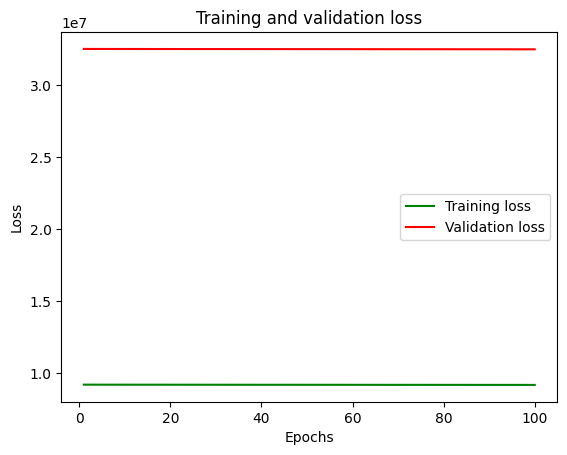

In [52]:
# Plot the training and validation loss over the epochs
train_loss_LSTM = model_LSTM.history.history['loss']
val_loss_LSTM = model_LSTM.history.history['val_loss']
epochs = range(1, len(train_loss_LSTM) + 1)

plt.plot(epochs, train_loss_LSTM, color='green', label='Training loss')
plt.plot(epochs, val_loss_LSTM, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
p_path = plot_path + 'LSTM/loss/loss_prod_weather_LSTM_100E_64B_EL-5_2.png'
plt.savefig(p_path)

In [ ]:
model_LSTM.fit(X_train_val, X_train_val, validation_data=(X_test_local, y_test_local), epochs=epochs_LSTM, batch_size=batch_size_LSTM, verbose=2, callbacks=[cp_LSTM])

In [ ]:
# Plot the training and validation loss over the epochs
train_val_loss_LSTM = model_LSTM.history.history['loss']
test_loss_LSTM = model_LSTM.history.history['val_loss']
epochs = range(1, len(train_val_loss_LSTM) + 1)

plt.plot(epochs, train_val_loss_LSTM, color='green', label='Training loss')
plt.plot(epochs, test_loss_LSTM, color='red', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
p_path = plot_path + 'LSTM/loss_2/loss_prod_weather_LSTM_100E_128B_EL-4_2_2.png'
plt.savefig(p_path)

In [55]:
model_LSTM.fit(X_train_val_test, y_train_val_test, validation_data=(X_test, y_test), epochs=epochs_LSTM, batch_size=batch_size_LSTM, verbose=2, callbacks=[cp_LSTM])

Epoch 1/100
110/110 - 1s - loss: 16366820.0000 - root_mean_squared_error: 4045.5928 - val_loss: 62400064.0000 - val_root_mean_squared_error: 7899.3711 - 695ms/epoch - 6ms/step
Epoch 2/100
110/110 - 1s - loss: 16365313.0000 - root_mean_squared_error: 4045.4065 - val_loss: 62399012.0000 - val_root_mean_squared_error: 7899.3047 - 796ms/epoch - 7ms/step
Epoch 3/100
110/110 - 1s - loss: 16364308.0000 - root_mean_squared_error: 4045.2822 - val_loss: 62398076.0000 - val_root_mean_squared_error: 7899.2451 - 861ms/epoch - 8ms/step
Epoch 4/100
110/110 - 1s - loss: 16363646.0000 - root_mean_squared_error: 4045.2004 - val_loss: 62397504.0000 - val_root_mean_squared_error: 7899.2090 - 870ms/epoch - 8ms/step
Epoch 5/100
110/110 - 1s - loss: 16363069.0000 - root_mean_squared_error: 4045.1292 - val_loss: 62396912.0000 - val_root_mean_squared_error: 7899.1714 - 841ms/epoch - 8ms/step
Epoch 6/100
110/110 - 1s - loss: 16362533.0000 - root_mean_squared_error: 4045.0627 - val_loss: 62396360.0000 - val_root

In [56]:
test_predictions_LSTM = model_LSTM.predict(X_test).flatten()
y_test = y_test.flatten()
results_test_LSTM = pd.DataFrame(data={'Predictions':test_predictions_LSTM, 'Actuals':y_test})

55/55 [==============================] - 1s 3ms/step


### LSTM Plots&Results

In [57]:
# Obtain the scaling parameters (min and max) used during normalization
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]

# Denormalize the normalized values
results_test_LSTM['Predictions'] = scaler.inverse_transform(results_test_LSTM[['Predictions']])
results_test_LSTM['Actuals'] = scaler.inverse_transform(results_test_LSTM[['Actuals']])

In [58]:
timestamps = pd.date_range(end="2013-12-31 23:00:00", periods=1749, freq="1H")
results_test_LSTM.insert(0, 'Date', timestamps)
results_test_LSTM = results_test_LSTM.set_index("Date")
r_path = results_path + 'results_test_prod_weather_LSTM.csv'
results_test_LSTM.to_csv(r_path)

In [59]:
#r_path = results_path + 'results_test_prod_weather_LSTM.csv'
#results_test_LSTM = pd.read_csv(r_path)
#results_test_LSTM['Date'] = pd.to_datetime(results_test_LSTM_1['Date'])
#results_test_LSTM = results_test_LSTM.set_index("Date")
#results_test_LSTM

<ipython-input-60-6a5a3664a682>:4: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=20)


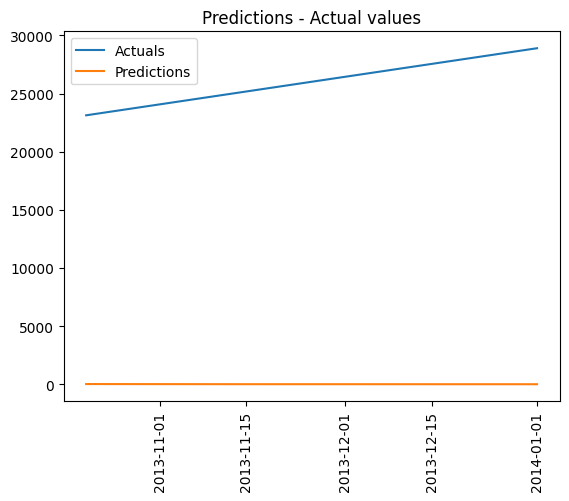

In [60]:
plt.plot(results_test_LSTM['Actuals'], label='Actuals')
plt.plot(results_test_LSTM['Predictions'], label='Predictions')
plt.xticks(rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.legend()
plt.title('Predictions - Actual values')
p_path = plot_path + 'LSTM/results_test_prod_weather_LSTM.png'
plt.savefig(p_path)

<ipython-input-61-7e6f4381bbeb>:5: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=20)


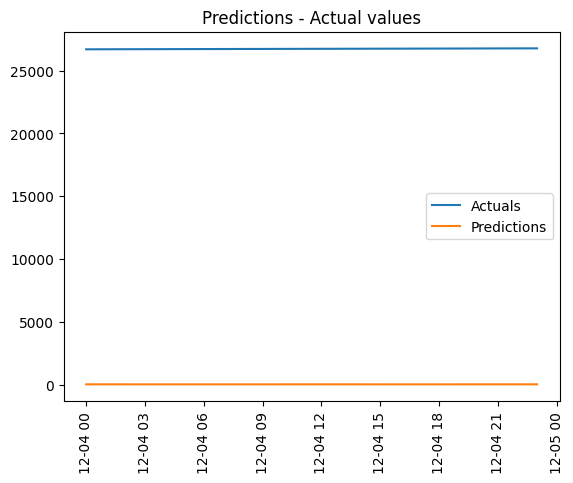

In [61]:
results_test_day_LSTM = results_test_LSTM.loc['2013-12-04']
plt.plot(results_test_day_LSTM['Actuals'], label='Actuals')
plt.plot(results_test_day_LSTM['Predictions'], label='Predictions')
plt.xticks(rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.legend()
plt.title('Predictions - Actual values')
p_path = plot_path + 'LSTM/results_test_prod_weather_1204_LSTM.png'
plt.savefig(p_path)

In [62]:
# Calculate the root mean squared error and mae of the predictions
mse_LSTM = mean_squared_error(results_test_LSTM['Actuals'], results_test_LSTM['Predictions'])
mae_LSTM = mean_absolute_error(results_test_LSTM['Actuals'], results_test_LSTM['Predictions'])
rmse_LSTM = math.sqrt(mse_LSTM)
print('mse LSTM : ' + str(mse_LSTM))
print('mae LSTM: ' + str(mae_LSTM))
print('rmse LSTM: ' + str(rmse_LSTM))

mse LSTM : 678965121.7908561
mae LSTM: 26003.421929080803
rmse LSTM: 26056.95918158633


----------------------------------------------------------------------------------------------------


**Predictions**


In [63]:
results_LSTM = model_LSTM.predict(X1).flatten()
y1 = y1.flatten()
results_LSTM = pd.DataFrame(data={'Predictions':results_LSTM, 'Actuals':y1})

274/274 [==============================] - 1s 2ms/step


In [64]:
# Obtain the scaling parameters (min and max) used during normalization
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]

# Denormalize the normalized values
results_LSTM['Predictions'] = scaler.inverse_transform(results_LSTM[['Predictions']])
results_LSTM['Actuals'] = scaler.inverse_transform(results_LSTM[['Actuals']])

In [65]:
timestamps = pd.date_range(start="2013-01-01 4:00:00", periods=8757, freq="1H")
results_LSTM.insert(0, 'Date', timestamps)
results_LSTM = results_LSTM.set_index("Date")
r_path = results_path + 'results_prod_weather_LSTM.csv'
results_LSTM.to_csv(r_path)

In [66]:
#r_path = results_path + 'results_prod_weather_LSTM.csv'
#results_LSTM.to_csv(r_path)
#results_LSTM = read_csv(r_path)
#results_LSTM['Date'] = pd.to_datetime(results_LSTM_1['Date'])
#results_LSTM = results_LSTM.set_index("Date")
#results_LSTM

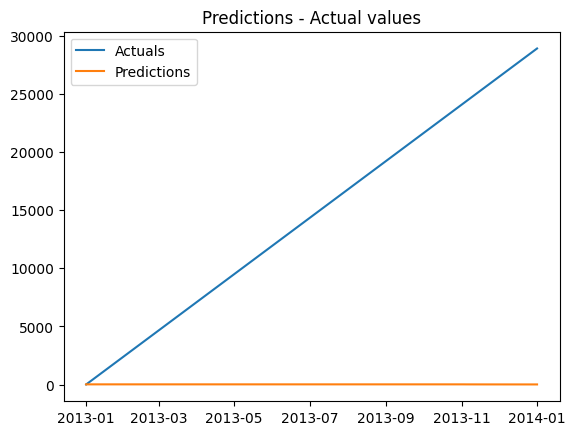

In [67]:
plt.plot(results_LSTM['Actuals'], label='Actuals')
plt.plot(results_LSTM['Predictions'], label='Predictions')
plt.legend()
plt.title('Predictions - Actual values')
plt.savefig('results_prod_weather_LSTM.png')

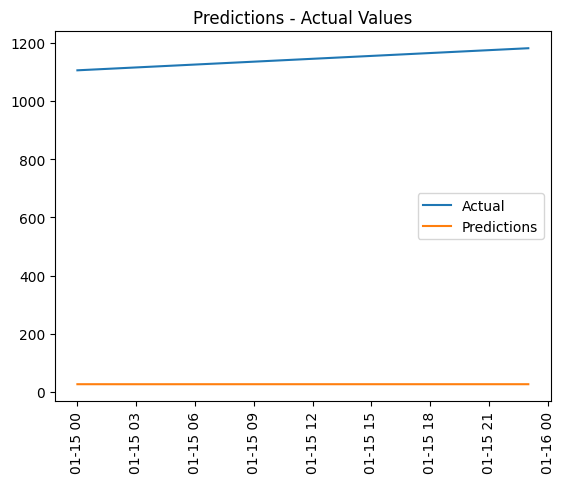

In [68]:
# Prediction of one day winter
results_day_LSTM = results_LSTM.loc['2013-01-15']
plt.plot( results_day_LSTM['Actuals'], label='Actual')
plt.plot(results_day_LSTM['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'LSTM/results_prod_weather_LSTM_winter.png'
plt.savefig(p_path)

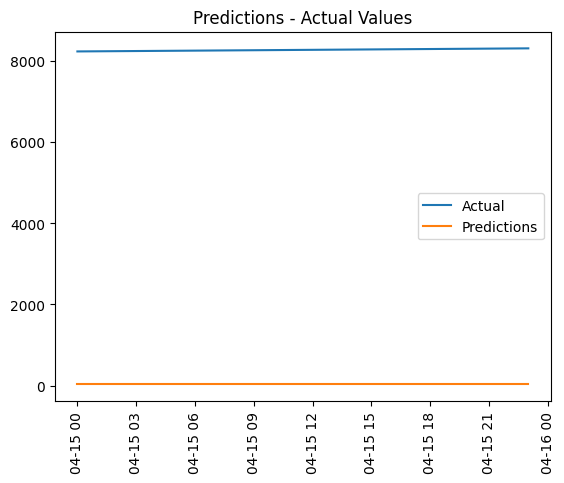

In [69]:
# Prediction of one day spring
results_day_LSTM = results_LSTM.loc['2013-04-15']
plt.plot( results_day_LSTM['Actuals'], label='Actual')
plt.plot(results_day_LSTM['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'LSTM/results_prod_weather_LSTM_spring.png'
plt.savefig(p_path)

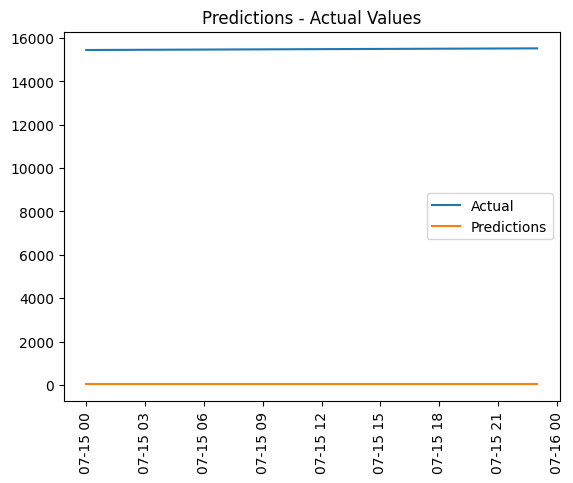

In [70]:
# Prediction of one day summer
results_day_LSTM = results_LSTM.loc['2013-07-15']
plt.plot( results_day_LSTM['Actuals'], label='Actual')
plt.plot(results_day_LSTM['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'LSTM/results_prod_weather_LSTM_summer.png'
plt.savefig(p_path)

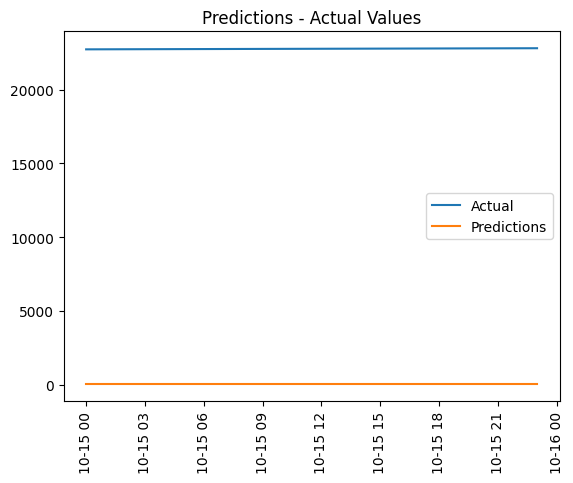

In [71]:
# Prediction of one day autumn
results_day_LSTM = results_LSTM.loc['2013-10-15']
plt.plot( results_day_LSTM['Actuals'], label='Actual')
plt.plot(results_day_LSTM['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'LSTM/results_prod_weather_LSTM_autumn.png'
plt.savefig(p_path)

In [72]:
# Calculate the root mean squared error and mae of the predictions
mse_LSTM = mean_squared_error(results_LSTM['Actuals'], results_LSTM['Predictions'])
mae_LSTM = mean_absolute_error(results_LSTM['Actuals'], results_LSTM['Predictions'])
rmse_LSTM = math.sqrt(mse_LSTM)
print('mse LSTM : ' + str(mse_LSTM))
print('mae LSTM: ' + str(mae_LSTM))
print('rmse LSTM: ' + str(rmse_LSTM))

mse LSTM : 277885449.12605274
mae LSTM: 14430.44989485236
rmse LSTM: 16669.896494161345


### GRU

In [78]:
learning_rate_GRU = 0.00001
epochs_GRU = 100
batch_size_GRU = 32

In [79]:
model_GRU = Sequential()
model_GRU.add(InputLayer((3, 24)))
model_GRU.add(GRU(64))
model_GRU.add(Dense(8, 'relu'))
model_GRU.add(Dense(1, 'linear'))
model_GRU.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                17280     
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dense_13 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17,809
Trainable params: 17,809
Non-trainable params: 0
_________________________________________________________________


In [80]:
cp_GRU = ModelCheckpoint('/content/gdrive/MyDrive/Tesi/data/Dati/models/production_weather_OHE/model_GRU/', save_best_only=True)
model_GRU.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate_GRU), metrics=[RootMeanSquaredError()])

In [81]:
model_GRU.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs_GRU, batch_size=batch_size_GRU, verbose=2, callbacks=[cp_GRU])

Epoch 1/100


165/165 - 9s - loss: 9219652.0000 - root_mean_squared_error: 3036.3879 - val_loss: 32514424.0000 - val_root_mean_squared_error: 5702.1421 - 9s/epoch - 55ms/step
Epoch 2/100


165/165 - 6s - loss: 9218721.0000 - root_mean_squared_error: 3036.2346 - val_loss: 32513172.0000 - val_root_mean_squared_error: 5702.0322 - 6s/epoch - 35ms/step
Epoch 3/100


165/165 - 5s - loss: 9217719.0000 - root_mean_squared_error: 3036.0696 - val_loss: 32512088.0000 - val_root_mean_squared_error: 5701.9370 - 5s/epoch - 32ms/step
Epoch 4/100


165/165 - 6s - loss: 9216872.0000 - root_mean_squared_error: 3035.9302 - val_loss: 32511224.0000 - val_root_mean_squared_error: 5701.8613 - 6s/epoch - 35ms/step
Epoch 5/100


165/165 - 6s - loss: 9215825.0000 - root_mean_squared_error: 3035.7578 - val_loss: 32509312.0000 - val_root_mean_squared_error: 5701.6938 - 6s/epoch - 37ms/step
Epoch 6/100


165/165 - 6s - loss: 9213922.0000 - root_mean_squared_error: 3035.4443 - val_loss: 32503858.0000 - val_root_mean_squared_error: 5701.2153 - 6s/epoch - 38ms/step
Epoch 7/100


165/165 - 7s - loss: 9213339.0000 - root_mean_squared_error: 3035.3481 - val_loss: 32502752.0000 - val_root_mean_squared_error: 5701.1187 - 7s/epoch - 41ms/step
Epoch 8/100


165/165 - 5s - loss: 9212873.0000 - root_mean_squared_error: 3035.2715 - val_loss: 32501980.0000 - val_root_mean_squared_error: 5701.0508 - 5s/epoch - 30ms/step
Epoch 9/100


165/165 - 6s - loss: 9212439.0000 - root_mean_squared_error: 3035.2000 - val_loss: 32501294.0000 - val_root_mean_squared_error: 5700.9907 - 6s/epoch - 34ms/step
Epoch 10/100


165/165 - 6s - loss: 9211954.0000 - root_mean_squared_error: 3035.1201 - val_loss: 32500648.0000 - val_root_mean_squared_error: 5700.9341 - 6s/epoch - 39ms/step
Epoch 11/100


165/165 - 5s - loss: 9211501.0000 - root_mean_squared_error: 3035.0454 - val_loss: 32499998.0000 - val_root_mean_squared_error: 5700.8770 - 5s/epoch - 31ms/step
Epoch 12/100


165/165 - 6s - loss: 9210942.0000 - root_mean_squared_error: 3034.9534 - val_loss: 32499168.0000 - val_root_mean_squared_error: 5700.8042 - 6s/epoch - 37ms/step
Epoch 13/100


165/165 - 6s - loss: 9210478.0000 - root_mean_squared_error: 3034.8770 - val_loss: 32498256.0000 - val_root_mean_squared_error: 5700.7241 - 6s/epoch - 35ms/step
Epoch 14/100


165/165 - 6s - loss: 9210099.0000 - root_mean_squared_error: 3034.8145 - val_loss: 32497514.0000 - val_root_mean_squared_error: 5700.6592 - 6s/epoch - 36ms/step
Epoch 15/100


165/165 - 5s - loss: 9209743.0000 - root_mean_squared_error: 3034.7559 - val_loss: 32496808.0000 - val_root_mean_squared_error: 5700.5972 - 5s/epoch - 32ms/step
Epoch 16/100


165/165 - 6s - loss: 9209390.0000 - root_mean_squared_error: 3034.6978 - val_loss: 32496058.0000 - val_root_mean_squared_error: 5700.5312 - 6s/epoch - 37ms/step
Epoch 17/100


165/165 - 6s - loss: 9209038.0000 - root_mean_squared_error: 3034.6396 - val_loss: 32495224.0000 - val_root_mean_squared_error: 5700.4580 - 6s/epoch - 36ms/step
Epoch 18/100


165/165 - 5s - loss: 9208667.0000 - root_mean_squared_error: 3034.5786 - val_loss: 32494324.0000 - val_root_mean_squared_error: 5700.3794 - 5s/epoch - 31ms/step
Epoch 19/100


165/165 - 7s - loss: 9208285.0000 - root_mean_squared_error: 3034.5156 - val_loss: 32493360.0000 - val_root_mean_squared_error: 5700.2949 - 7s/epoch - 44ms/step
Epoch 20/100


165/165 - 5s - loss: 9207880.0000 - root_mean_squared_error: 3034.4490 - val_loss: 32492366.0000 - val_root_mean_squared_error: 5700.2075 - 5s/epoch - 32ms/step
Epoch 21/100


165/165 - 6s - loss: 9207453.0000 - root_mean_squared_error: 3034.3784 - val_loss: 32491324.0000 - val_root_mean_squared_error: 5700.1162 - 6s/epoch - 37ms/step
Epoch 22/100


165/165 - 7s - loss: 9206970.0000 - root_mean_squared_error: 3034.2988 - val_loss: 32490028.0000 - val_root_mean_squared_error: 5700.0024 - 7s/epoch - 40ms/step
Epoch 23/100


165/165 - 5s - loss: 9206342.0000 - root_mean_squared_error: 3034.1956 - val_loss: 32488816.0000 - val_root_mean_squared_error: 5699.8960 - 5s/epoch - 32ms/step
Epoch 24/100


165/165 - 6s - loss: 9205397.0000 - root_mean_squared_error: 3034.0398 - val_loss: 32487438.0000 - val_root_mean_squared_error: 5699.7754 - 6s/epoch - 39ms/step
Epoch 25/100


165/165 - 6s - loss: 9204314.0000 - root_mean_squared_error: 3033.8613 - val_loss: 32486104.0000 - val_root_mean_squared_error: 5699.6582 - 6s/epoch - 35ms/step
Epoch 26/100


165/165 - 6s - loss: 9203324.0000 - root_mean_squared_error: 3033.6980 - val_loss: 32484654.0000 - val_root_mean_squared_error: 5699.5312 - 6s/epoch - 38ms/step
Epoch 27/100


165/165 - 5s - loss: 9202422.0000 - root_mean_squared_error: 3033.5493 - val_loss: 32483398.0000 - val_root_mean_squared_error: 5699.4209 - 5s/epoch - 31ms/step
Epoch 28/100


165/165 - 6s - loss: 9201553.0000 - root_mean_squared_error: 3033.4062 - val_loss: 32482350.0000 - val_root_mean_squared_error: 5699.3291 - 6s/epoch - 39ms/step
Epoch 29/100


165/165 - 6s - loss: 9200786.0000 - root_mean_squared_error: 3033.2798 - val_loss: 32481308.0000 - val_root_mean_squared_error: 5699.2373 - 6s/epoch - 34ms/step
Epoch 30/100


165/165 - 5s - loss: 9200059.0000 - root_mean_squared_error: 3033.1599 - val_loss: 32480188.0000 - val_root_mean_squared_error: 5699.1392 - 5s/epoch - 31ms/step
Epoch 31/100


165/165 - 7s - loss: 9199349.0000 - root_mean_squared_error: 3033.0430 - val_loss: 32479000.0000 - val_root_mean_squared_error: 5699.0352 - 7s/epoch - 44ms/step
Epoch 32/100


165/165 - 5s - loss: 9198603.0000 - root_mean_squared_error: 3032.9199 - val_loss: 32477724.0000 - val_root_mean_squared_error: 5698.9229 - 5s/epoch - 31ms/step
Epoch 33/100


165/165 - 6s - loss: 9197839.0000 - root_mean_squared_error: 3032.7939 - val_loss: 32476404.0000 - val_root_mean_squared_error: 5698.8071 - 6s/epoch - 36ms/step
Epoch 34/100


165/165 - 6s - loss: 9197101.0000 - root_mean_squared_error: 3032.6724 - val_loss: 32475082.0000 - val_root_mean_squared_error: 5698.6914 - 6s/epoch - 35ms/step
Epoch 35/100


165/165 - 6s - loss: 9196359.0000 - root_mean_squared_error: 3032.5498 - val_loss: 32473752.0000 - val_root_mean_squared_error: 5698.5747 - 6s/epoch - 37ms/step
Epoch 36/100


165/165 - 6s - loss: 9195635.0000 - root_mean_squared_error: 3032.4307 - val_loss: 32472452.0000 - val_root_mean_squared_error: 5698.4604 - 6s/epoch - 38ms/step
Epoch 37/100


165/165 - 7s - loss: 9194895.0000 - root_mean_squared_error: 3032.3086 - val_loss: 32471150.0000 - val_root_mean_squared_error: 5698.3462 - 7s/epoch - 42ms/step
Epoch 38/100


165/165 - 7s - loss: 9194149.0000 - root_mean_squared_error: 3032.1855 - val_loss: 32469860.0000 - val_root_mean_squared_error: 5698.2329 - 7s/epoch - 41ms/step
Epoch 39/100


165/165 - 5s - loss: 9193385.0000 - root_mean_squared_error: 3032.0596 - val_loss: 32468574.0000 - val_root_mean_squared_error: 5698.1201 - 5s/epoch - 31ms/step
Epoch 40/100


165/165 - 7s - loss: 9192620.0000 - root_mean_squared_error: 3031.9333 - val_loss: 32467298.0000 - val_root_mean_squared_error: 5698.0083 - 7s/epoch - 40ms/step
Epoch 41/100


165/165 - 6s - loss: 9191850.0000 - root_mean_squared_error: 3031.8064 - val_loss: 32466008.0000 - val_root_mean_squared_error: 5697.8950 - 6s/epoch - 37ms/step
Epoch 42/100


165/165 - 6s - loss: 9191061.0000 - root_mean_squared_error: 3031.6763 - val_loss: 32464726.0000 - val_root_mean_squared_error: 5697.7827 - 6s/epoch - 36ms/step
Epoch 43/100


165/165 - 6s - loss: 9190233.0000 - root_mean_squared_error: 3031.5398 - val_loss: 32463446.0000 - val_root_mean_squared_error: 5697.6704 - 6s/epoch - 39ms/step
Epoch 44/100


165/165 - 10s - loss: 9189374.0000 - root_mean_squared_error: 3031.3979 - val_loss: 32462168.0000 - val_root_mean_squared_error: 5697.5581 - 10s/epoch - 59ms/step
Epoch 45/100


165/165 - 5s - loss: 9188488.0000 - root_mean_squared_error: 3031.2520 - val_loss: 32460886.0000 - val_root_mean_squared_error: 5697.4458 - 5s/epoch - 32ms/step
Epoch 46/100


165/165 - 7s - loss: 9187603.0000 - root_mean_squared_error: 3031.1060 - val_loss: 32459600.0000 - val_root_mean_squared_error: 5697.3325 - 7s/epoch - 40ms/step
Epoch 47/100


165/165 - 6s - loss: 9186727.0000 - root_mean_squared_error: 3030.9614 - val_loss: 32458306.0000 - val_root_mean_squared_error: 5697.2192 - 6s/epoch - 36ms/step
Epoch 48/100


165/165 - 5s - loss: 9185909.0000 - root_mean_squared_error: 3030.8264 - val_loss: 32456980.0000 - val_root_mean_squared_error: 5697.1025 - 5s/epoch - 31ms/step
Epoch 49/100


165/165 - 6s - loss: 9184984.0000 - root_mean_squared_error: 3030.6738 - val_loss: 32455642.0000 - val_root_mean_squared_error: 5696.9854 - 6s/epoch - 39ms/step
Epoch 50/100


165/165 - 6s - loss: 9184077.0000 - root_mean_squared_error: 3030.5242 - val_loss: 32454214.0000 - val_root_mean_squared_error: 5696.8599 - 6s/epoch - 37ms/step
Epoch 51/100


165/165 - 6s - loss: 9183195.0000 - root_mean_squared_error: 3030.3787 - val_loss: 32452844.0000 - val_root_mean_squared_error: 5696.7397 - 6s/epoch - 37ms/step
Epoch 52/100


165/165 - 6s - loss: 9182297.0000 - root_mean_squared_error: 3030.2305 - val_loss: 32451500.0000 - val_root_mean_squared_error: 5696.6216 - 6s/epoch - 39ms/step
Epoch 53/100


165/165 - 6s - loss: 9181423.0000 - root_mean_squared_error: 3030.0862 - val_loss: 32450144.0000 - val_root_mean_squared_error: 5696.5029 - 6s/epoch - 35ms/step
Epoch 54/100


165/165 - 6s - loss: 9180444.0000 - root_mean_squared_error: 3029.9248 - val_loss: 32448792.0000 - val_root_mean_squared_error: 5696.3843 - 6s/epoch - 36ms/step
Epoch 55/100


165/165 - 6s - loss: 9179450.0000 - root_mean_squared_error: 3029.7607 - val_loss: 32447422.0000 - val_root_mean_squared_error: 5696.2637 - 6s/epoch - 37ms/step
Epoch 56/100


165/165 - 6s - loss: 9178502.0000 - root_mean_squared_error: 3029.6042 - val_loss: 32446052.0000 - val_root_mean_squared_error: 5696.1436 - 6s/epoch - 39ms/step
Epoch 57/100


165/165 - 5s - loss: 9177510.0000 - root_mean_squared_error: 3029.4404 - val_loss: 32444682.0000 - val_root_mean_squared_error: 5696.0234 - 5s/epoch - 31ms/step
Epoch 58/100


165/165 - 8s - loss: 9176466.0000 - root_mean_squared_error: 3029.2683 - val_loss: 32443306.0000 - val_root_mean_squared_error: 5695.9023 - 8s/epoch - 46ms/step
Epoch 59/100


165/165 - 6s - loss: 9175310.0000 - root_mean_squared_error: 3029.0774 - val_loss: 32441830.0000 - val_root_mean_squared_error: 5695.7729 - 6s/epoch - 34ms/step
Epoch 60/100


165/165 - 6s - loss: 9174224.0000 - root_mean_squared_error: 3028.8982 - val_loss: 32440000.0000 - val_root_mean_squared_error: 5695.6123 - 6s/epoch - 39ms/step
Epoch 61/100


165/165 - 7s - loss: 9173255.0000 - root_mean_squared_error: 3028.7383 - val_loss: 32438446.0000 - val_root_mean_squared_error: 5695.4761 - 7s/epoch - 40ms/step
Epoch 62/100


165/165 - 6s - loss: 9172207.0000 - root_mean_squared_error: 3028.5652 - val_loss: 32436870.0000 - val_root_mean_squared_error: 5695.3374 - 6s/epoch - 38ms/step
Epoch 63/100


165/165 - 6s - loss: 9171066.0000 - root_mean_squared_error: 3028.3767 - val_loss: 32435300.0000 - val_root_mean_squared_error: 5695.1997 - 6s/epoch - 36ms/step
Epoch 64/100


165/165 - 5s - loss: 9169999.0000 - root_mean_squared_error: 3028.2007 - val_loss: 32433744.0000 - val_root_mean_squared_error: 5695.0630 - 5s/epoch - 31ms/step
Epoch 65/100


165/165 - 7s - loss: 9168939.0000 - root_mean_squared_error: 3028.0256 - val_loss: 32432156.0000 - val_root_mean_squared_error: 5694.9238 - 7s/epoch - 45ms/step
Epoch 66/100


165/165 - 6s - loss: 9167876.0000 - root_mean_squared_error: 3027.8501 - val_loss: 32430538.0000 - val_root_mean_squared_error: 5694.7817 - 6s/epoch - 36ms/step
Epoch 67/100


165/165 - 8s - loss: 9166784.0000 - root_mean_squared_error: 3027.6697 - val_loss: 32428868.0000 - val_root_mean_squared_error: 5694.6353 - 8s/epoch - 47ms/step
Epoch 68/100


165/165 - 5s - loss: 9165697.0000 - root_mean_squared_error: 3027.4902 - val_loss: 32427182.0000 - val_root_mean_squared_error: 5694.4868 - 5s/epoch - 32ms/step
Epoch 69/100


165/165 - 6s - loss: 9164543.0000 - root_mean_squared_error: 3027.2996 - val_loss: 32425494.0000 - val_root_mean_squared_error: 5694.3389 - 6s/epoch - 36ms/step
Epoch 70/100


165/165 - 6s - loss: 9163405.0000 - root_mean_squared_error: 3027.1116 - val_loss: 32423802.0000 - val_root_mean_squared_error: 5694.1904 - 6s/epoch - 39ms/step
Epoch 71/100


165/165 - 5s - loss: 9162270.0000 - root_mean_squared_error: 3026.9241 - val_loss: 32422118.0000 - val_root_mean_squared_error: 5694.0425 - 5s/epoch - 31ms/step
Epoch 72/100


165/165 - 6s - loss: 9161096.0000 - root_mean_squared_error: 3026.7302 - val_loss: 32420424.0000 - val_root_mean_squared_error: 5693.8936 - 6s/epoch - 38ms/step
Epoch 73/100


165/165 - 6s - loss: 9159873.0000 - root_mean_squared_error: 3026.5283 - val_loss: 32418722.0000 - val_root_mean_squared_error: 5693.7441 - 6s/epoch - 35ms/step
Epoch 74/100


165/165 - 6s - loss: 9158655.0000 - root_mean_squared_error: 3026.3269 - val_loss: 32417020.0000 - val_root_mean_squared_error: 5693.5947 - 6s/epoch - 39ms/step
Epoch 75/100


165/165 - 5s - loss: 9157380.0000 - root_mean_squared_error: 3026.1162 - val_loss: 32415306.0000 - val_root_mean_squared_error: 5693.4443 - 5s/epoch - 32ms/step
Epoch 76/100


165/165 - 6s - loss: 9156006.0000 - root_mean_squared_error: 3025.8894 - val_loss: 32413554.0000 - val_root_mean_squared_error: 5693.2900 - 6s/epoch - 33ms/step
Epoch 77/100


165/165 - 7s - loss: 9154650.0000 - root_mean_squared_error: 3025.6653 - val_loss: 32411716.0000 - val_root_mean_squared_error: 5693.1289 - 7s/epoch - 41ms/step
Epoch 78/100


165/165 - 5s - loss: 9153328.0000 - root_mean_squared_error: 3025.4468 - val_loss: 32409804.0000 - val_root_mean_squared_error: 5692.9609 - 5s/epoch - 32ms/step
Epoch 79/100


165/165 - 8s - loss: 9152022.0000 - root_mean_squared_error: 3025.2310 - val_loss: 32408026.0000 - val_root_mean_squared_error: 5692.8047 - 8s/epoch - 46ms/step
Epoch 80/100


165/165 - 5s - loss: 9150729.0000 - root_mean_squared_error: 3025.0171 - val_loss: 32406266.0000 - val_root_mean_squared_error: 5692.6504 - 5s/epoch - 32ms/step
Epoch 81/100


165/165 - 6s - loss: 9149318.0000 - root_mean_squared_error: 3024.7839 - val_loss: 32404496.0000 - val_root_mean_squared_error: 5692.4946 - 6s/epoch - 38ms/step
Epoch 82/100


165/165 - 6s - loss: 9147934.0000 - root_mean_squared_error: 3024.5552 - val_loss: 32402724.0000 - val_root_mean_squared_error: 5692.3389 - 6s/epoch - 36ms/step
Epoch 83/100


165/165 - 6s - loss: 9146515.0000 - root_mean_squared_error: 3024.3206 - val_loss: 32400960.0000 - val_root_mean_squared_error: 5692.1841 - 6s/epoch - 35ms/step
Epoch 84/100


165/165 - 6s - loss: 9145060.0000 - root_mean_squared_error: 3024.0801 - val_loss: 32399294.0000 - val_root_mean_squared_error: 5692.0376 - 6s/epoch - 35ms/step
Epoch 85/100


165/165 - 6s - loss: 9143534.0000 - root_mean_squared_error: 3023.8276 - val_loss: 32397284.0000 - val_root_mean_squared_error: 5691.8613 - 6s/epoch - 37ms/step
Epoch 86/100


165/165 - 6s - loss: 9142175.0000 - root_mean_squared_error: 3023.6030 - val_loss: 32395358.0000 - val_root_mean_squared_error: 5691.6919 - 6s/epoch - 39ms/step
Epoch 87/100


165/165 - 5s - loss: 9140822.0000 - root_mean_squared_error: 3023.3792 - val_loss: 32393460.0000 - val_root_mean_squared_error: 5691.5254 - 5s/epoch - 31ms/step
Epoch 88/100


165/165 - 6s - loss: 9139451.0000 - root_mean_squared_error: 3023.1526 - val_loss: 32391542.0000 - val_root_mean_squared_error: 5691.3569 - 6s/epoch - 38ms/step
Epoch 89/100


165/165 - 6s - loss: 9138116.0000 - root_mean_squared_error: 3022.9316 - val_loss: 32389522.0000 - val_root_mean_squared_error: 5691.1792 - 6s/epoch - 39ms/step
Epoch 90/100


165/165 - 6s - loss: 9136725.0000 - root_mean_squared_error: 3022.7017 - val_loss: 32387542.0000 - val_root_mean_squared_error: 5691.0054 - 6s/epoch - 34ms/step
Epoch 91/100


165/165 - 7s - loss: 9135318.0000 - root_mean_squared_error: 3022.4688 - val_loss: 32384914.0000 - val_root_mean_squared_error: 5690.7744 - 7s/epoch - 41ms/step
Epoch 92/100


165/165 - 6s - loss: 9134049.0000 - root_mean_squared_error: 3022.2590 - val_loss: 32382708.0000 - val_root_mean_squared_error: 5690.5806 - 6s/epoch - 34ms/step
Epoch 93/100


165/165 - 6s - loss: 9132797.0000 - root_mean_squared_error: 3022.0518 - val_loss: 32380798.0000 - val_root_mean_squared_error: 5690.4126 - 6s/epoch - 38ms/step
Epoch 94/100


165/165 - 6s - loss: 9131497.0000 - root_mean_squared_error: 3021.8367 - val_loss: 32378876.0000 - val_root_mean_squared_error: 5690.2441 - 6s/epoch - 37ms/step
Epoch 95/100


165/165 - 6s - loss: 9130205.0000 - root_mean_squared_error: 3021.6228 - val_loss: 32376958.0000 - val_root_mean_squared_error: 5690.0752 - 6s/epoch - 39ms/step
Epoch 96/100


165/165 - 5s - loss: 9128898.0000 - root_mean_squared_error: 3021.4067 - val_loss: 32375030.0000 - val_root_mean_squared_error: 5689.9058 - 5s/epoch - 30ms/step
Epoch 97/100


165/165 - 8s - loss: 9127571.0000 - root_mean_squared_error: 3021.1870 - val_loss: 32373096.0000 - val_root_mean_squared_error: 5689.7358 - 8s/epoch - 48ms/step
Epoch 98/100


165/165 - 6s - loss: 9126237.0000 - root_mean_squared_error: 3020.9663 - val_loss: 32371150.0000 - val_root_mean_squared_error: 5689.5649 - 6s/epoch - 37ms/step
Epoch 99/100


165/165 - 5s - loss: 9124913.0000 - root_mean_squared_error: 3020.7471 - val_loss: 32369204.0000 - val_root_mean_squared_error: 5689.3940 - 5s/epoch - 32ms/step
Epoch 100/100


165/165 - 6s - loss: 9123577.0000 - root_mean_squared_error: 3020.5259 - val_loss: 32367244.0000 - val_root_mean_squared_error: 5689.2217 - 6s/epoch - 39ms/step


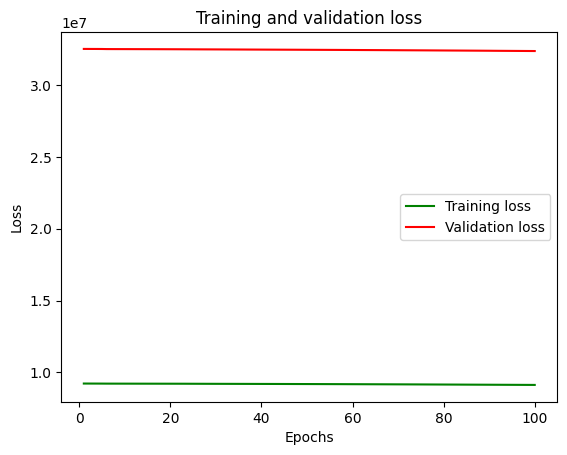

In [83]:
# Plot the training and validation loss over the epochs
train_loss_GRU = model_GRU.history.history['loss']
val_loss_GRU = model_GRU.history.history['val_loss']
epochs = range(1, len(train_loss_GRU) + 1)

plt.plot(epochs, train_loss_GRU, color='green', label='Training loss')
plt.plot(epochs, val_loss_GRU, color='red', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show()
p_path = plot_path + 'GRU/loss/loss_prod_weather_GRU_100E_32B_EL-5_2.png'
plt.savefig(p_path)

In [84]:
model_GRU.fit(X_train_val, y_train_val, validation_data=(X_test_local, y_test_local), epochs=epochs_GRU, batch_size=batch_size_GRU, verbose=2, callbacks=[cp_GRU])

Epoch 1/100
192/192 - 1s - loss: 12438014.0000 - root_mean_squared_error: 3526.7568 - val_loss: 43102384.0000 - val_root_mean_squared_error: 6565.2407 - 1s/epoch - 7ms/step
Epoch 2/100
192/192 - 1s - loss: 12432997.0000 - root_mean_squared_error: 3526.0454 - val_loss: 43097472.0000 - val_root_mean_squared_error: 6564.8667 - 1s/epoch - 6ms/step
Epoch 3/100
192/192 - 1s - loss: 12430311.0000 - root_mean_squared_error: 3525.6646 - val_loss: 43093424.0000 - val_root_mean_squared_error: 6564.5581 - 876ms/epoch - 5ms/step
Epoch 4/100
192/192 - 1s - loss: 12428190.0000 - root_mean_squared_error: 3525.3638 - val_loss: 43089980.0000 - val_root_mean_squared_error: 6564.2959 - 922ms/epoch - 5ms/step
Epoch 5/100
192/192 - 1s - loss: 12426175.0000 - root_mean_squared_error: 3525.0781 - val_loss: 43086920.0000 - val_root_mean_squared_error: 6564.0630 - 875ms/epoch - 5ms/step
Epoch 6/100
192/192 - 1s - loss: 12424165.0000 - root_mean_squared_error: 3524.7930 - val_loss: 43083944.0000 - val_root_mean_

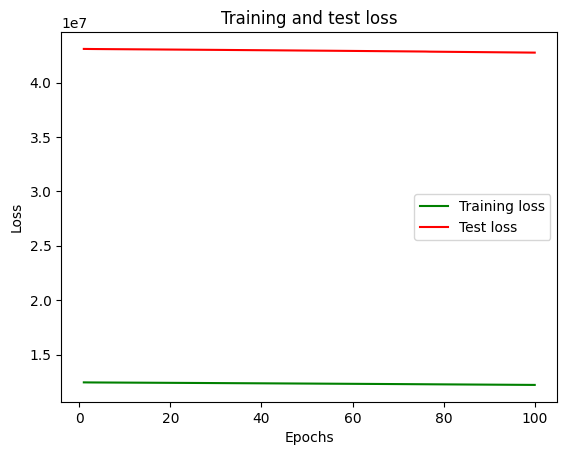

In [85]:
# Plot the training and validation loss over the epochs
train_val_loss_GRU = model_GRU.history.history['loss']
test_loss_GRU = model_GRU.history.history['val_loss']
epochs = range(1, len(train_val_loss_GRU) + 1)

plt.plot(epochs, train_val_loss_GRU, color='green', label='Training loss')
plt.plot(epochs, test_loss_GRU, color='red', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
p_path = plot_path + 'GRU/loss_2/loss_prod_weather_GRU_100E_32B_EL-5_2.png'
plt.savefig(p_path)

In [86]:
model_GRU.fit(X_train_val_test, y_train_val_test, validation_data=(X_test, y_test), epochs=epochs_GRU, batch_size=batch_size_GRU, verbose=2, callbacks=[cp_GRU])

Epoch 1/100
219/219 - 1s - loss: 16002214.0000 - root_mean_squared_error: 4000.2769 - val_loss: 61980044.0000 - val_root_mean_squared_error: 7872.7407 - 1s/epoch - 5ms/step
Epoch 2/100
219/219 - 1s - loss: 15988757.0000 - root_mean_squared_error: 3998.5945 - val_loss: 61970936.0000 - val_root_mean_squared_error: 7872.1621 - 1s/epoch - 5ms/step
Epoch 3/100
219/219 - 1s - loss: 15983064.0000 - root_mean_squared_error: 3997.8823 - val_loss: 61964840.0000 - val_root_mean_squared_error: 7871.7749 - 1s/epoch - 5ms/step
Epoch 4/100
219/219 - 1s - loss: 15978933.0000 - root_mean_squared_error: 3997.3657 - val_loss: 61960488.0000 - val_root_mean_squared_error: 7871.4985 - 1s/epoch - 5ms/step
Epoch 5/100
219/219 - 1s - loss: 15974714.0000 - root_mean_squared_error: 3996.8379 - val_loss: 61955660.0000 - val_root_mean_squared_error: 7871.1919 - 1s/epoch - 5ms/step
Epoch 6/100
219/219 - 1s - loss: 15971057.0000 - root_mean_squared_error: 3996.3804 - val_loss: 61950860.0000 - val_root_mean_squared_e

In [87]:
test_predictions_GRU = model_GRU.predict(X_test).flatten().tolist()
y_test = y_test.flatten()
results_test_GRU = pd.DataFrame(data={'Predictions':test_predictions_GRU, 'Actuals':y_test})

55/55 [==============================] - 1s 2ms/step


### GRU Plots&Results

In [88]:
# Obtain the scaling parameters (min and max) used during normalization
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]

# Denormalize the selected column
results_test_GRU['Predictions'] = scaler.inverse_transform(results_test_GRU[['Predictions']])
results_test_GRU['Actuals'] = scaler.inverse_transform(results_test_GRU[['Actuals']])

In [89]:
timestamps = pd.date_range(end="2013-12-31 23:00:00", periods=1749, freq="1H")
results_test_GRU.insert(0, 'Date', timestamps)
results_test_GRU = results_test_GRU.set_index("Date")
r_path = results_path + 'results_test_prod_weather_GRU.csv'
results_test_GRU.to_csv(r_path)

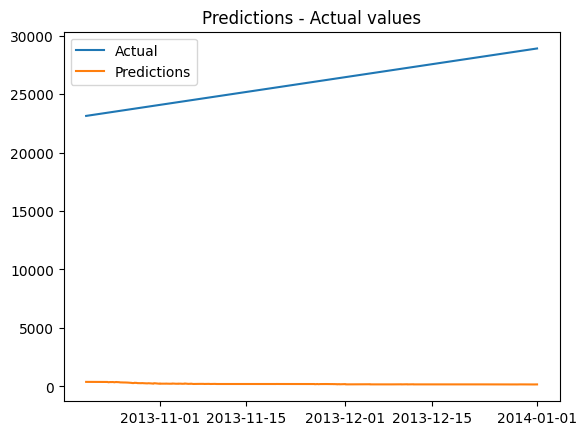

In [90]:
plt.plot(results_test_GRU['Actuals'], label='Actual')
plt.plot(results_test_GRU['Predictions'], label='Predictions')
plt.legend()
plt.title('Predictions - Actual values')
p_path = plot_path + 'GRU/results_test_prod_weather_GRU.png'
plt.savefig(p_path)

<ipython-input-91-5c9bdb172c76>:5: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.dates.AutoDateLocator'>
  plt.locator_params(axis='x', nbins=20)


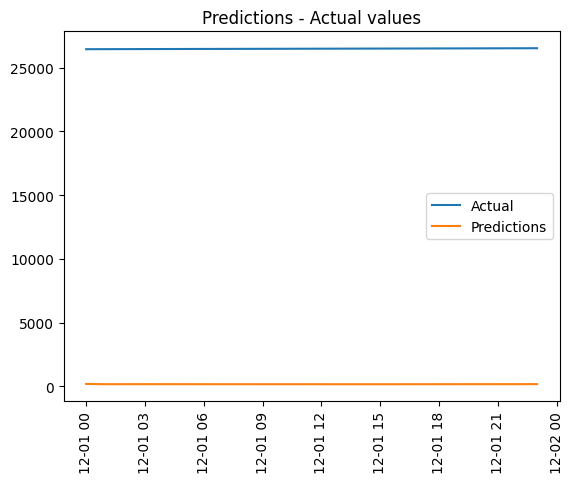

In [91]:
results_test_day_GRU = results_test_GRU.loc['2013-12-01']
plt.plot(results_test_day_GRU['Actuals'], label='Actual')
plt.plot(results_test_day_GRU['Predictions'], label='Predictions')
plt.xticks(rotation='vertical')
plt.locator_params(axis='x', nbins=20)
plt.legend()
plt.title('Predictions - Actual values')
p_path = plot_path + 'GRU/results_test_prod_weather_1201_GRU.png'
plt.savefig(p_path)

In [92]:
mse_GRU = mean_squared_error(results_test_GRU['Actuals'], results_test_GRU['Predictions'])
mae_GRU = mean_absolute_error(results_test_GRU['Actuals'], results_test_GRU['Predictions'])
rmse_GRU = math.sqrt(mse_GRU)
print('mse GRU: ' + str(mse_GRU))
print('mae GRU: ' + str(mae_GRU))
print('rmse GRU: ' + str(rmse_GRU))

mse GRU: 669192115.126313
mae GRU: 25811.91733704333
rmse GRU: 25868.74784612338




---



**Predictions**

In [93]:
results_GRU = model_GRU.predict(X1).flatten()
y1 = y1.flatten()
results_GRU = pd.DataFrame(data={'Predictions':results_GRU, 'Actuals':y1})

274/274 [==============================] - 1s 2ms/step


In [94]:
# Obtain the scaling parameters (min and max) used during normalization
min_value = scaler.data_min_[0]
max_value = scaler.data_max_[0]

# Denormalize the selected column
results_GRU['Predictions'] = scaler.inverse_transform(results_GRU[['Predictions']])
results_GRU['Actuals'] = scaler.inverse_transform(results_GRU[['Actuals']])

In [95]:
timestamps = pd.date_range(start="2013-01-01 4:00:00", periods=8757, freq="1H")
results_GRU.insert(0, 'Date', timestamps)
results_GRU = results_GRU.set_index("Date")
r_path = results_path + 'results_prod_weather_GRU.csv'
results_GRU.to_csv(r_path)

In [96]:
#results_GRU = read_csv('/content/results_prod_weather_GRU.csv')

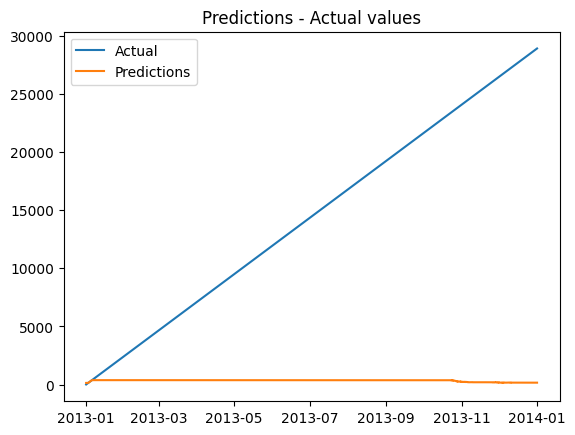

In [97]:
plt.plot(results_GRU['Actuals'], label='Actual')
plt.plot(results_GRU['Predictions'], label='Predictions')
plt.legend()
plt.title('Predictions - Actual values')
p_path = plot_path + 'GRU/results_test_prod_weather_GRU.png'
plt.savefig(p_path)

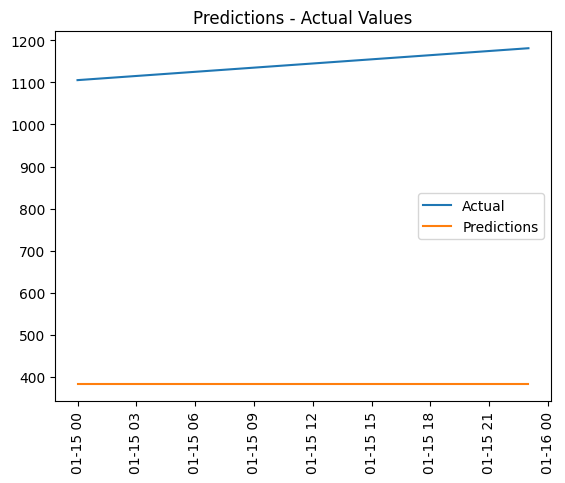

In [98]:
# Prediction of one day in winter
results_day_GRU = results_GRU.loc['2013-01-15']
plt.plot(results_day_GRU['Actuals'], label='Actual')
plt.plot(results_day_GRU['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'GRU/results_prod_weather_GRU_winter.png'
plt.savefig(p_path)

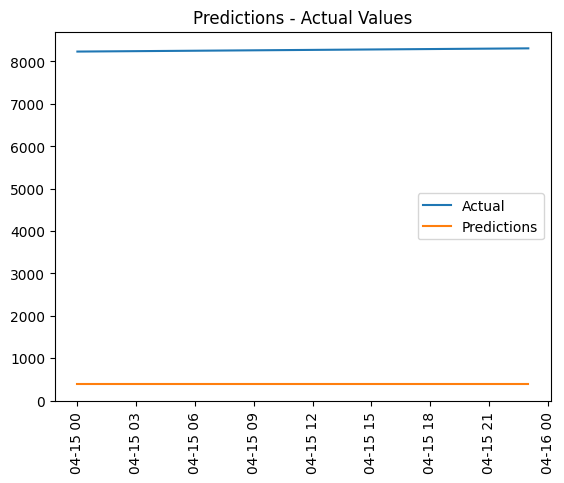

In [99]:
# Prediction of one day in spring
results_day_GRU = results_GRU.loc['2013-04-15']
plt.plot(results_day_GRU['Actuals'], label='Actual')
plt.plot(results_day_GRU['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'GRU/results_prod_weather_GRU_spring.png'
plt.savefig(p_path)

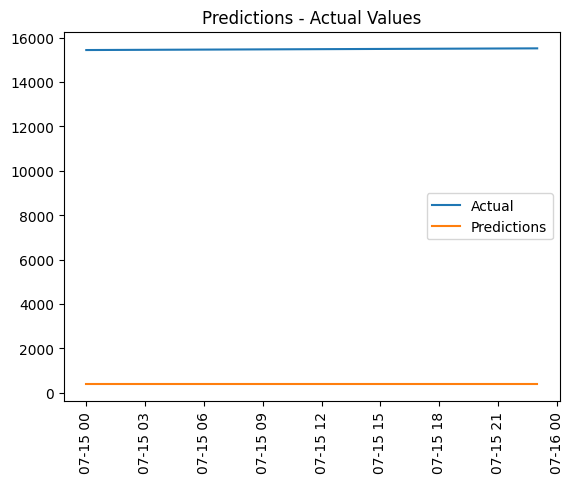

In [100]:
# Prediction of one day in summer
results_day_GRU = results_GRU.loc['2013-07-15']
plt.plot(results_day_GRU['Actuals'], label='Actual')
plt.plot(results_day_GRU['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'GRU/results_prod_weather_GRU_summer.png'
plt.savefig(p_path)

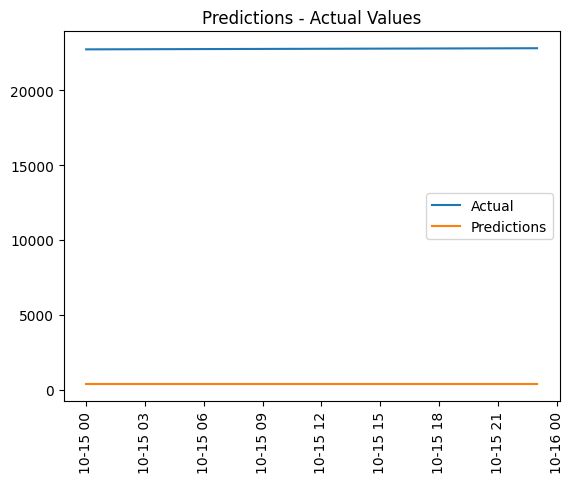

In [101]:
# Prediction of one day in autumn
results_day_GRU = results_GRU.loc['2013-10-15']
plt.plot(results_day_GRU['Actuals'], label='Actual')
plt.plot(results_day_GRU['Predictions'], label='Predictions')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Predictions - Actual Values')
p_path = plot_path + 'GRU/results_prod_weather_GRU_summer.png'
plt.savefig(p_path)

In [102]:
mse_GRU = mean_squared_error(results_GRU['Actuals'], results_GRU['Predictions'])
mae_GRU = mean_absolute_error(results_GRU['Actuals'], results_GRU['Predictions'])
rmse_GRU = math.sqrt(mse_GRU)
print('mse GRU: ' + str(mse_GRU))
print('mae GRU: ' + str(mae_GRU))
print('rmse GRU: ' + str(rmse_GRU))

mse GRU: 269517365.2810243
mae GRU: 14112.602121605938
rmse GRU: 16416.98404948437
